In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import sys
from importlib import reload
from scipy.stats import zscore
import scipy.io
from scipy.interpolate import make_interp_spline, BSpline
from scipy.signal import savgol_filter as savgol 
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import leidenalg
import umap
import gget

from pydmd import DMD

import matplotlib.pyplot as plt
import seaborn as sns

# local imports
sys.path.append("../python/")

import utils as ut
reload(ut)

import hasnain_DMD
reload(hasnain_DMD)

2023-09-19 13:59:42.484856: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-19 13:59:42.598810: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-19 13:59:42.598843: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-19 13:59:42.626106: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-19 13:59:43.927701: W tensorflow/stream_executor/pla

<module 'hasnain_DMD' from '/home/cstansbu/git_repositories/DMD_gene/notebooks/../python/hasnain_DMD.py'>

In [2]:
fpath = f"/nfs/turbo/umms-indikar/shared/projects/myod/clean_data/time_series_rna_Z_scores.csv"

"""Load the Z-score data frame """
df = pd.read_csv(fpath, index_col=0)
print(f"{df.shape=}")
gene_names = df.columns.to_list()
print(f"{len(gene_names)=}")

# structure the data for DMD
data = df.copy()
dmd_data = hasnain_DMD.data2dmd(data)
print(f"{dmd_data.shape=}")

# create a replicate averaged dataset
mu_data = df.copy()

mu_data = mu_data.reset_index(drop=False)
mu_data['time'] = mu_data['index'].apply(lambda x: x.split("_")[0].replace("T", ""))
mu_data['time'] = mu_data['time'].astype(int)
mu_data = mu_data.drop(columns=['index'])

mu_data = mu_data.groupby('time').mean().reset_index(drop=False)
mu_data = mu_data.sort_values(by='time')
mu_data = mu_data.set_index('time')

print(f"{mu_data.shape=}")

df.shape=(48, 20967)
len(gene_names)=20967
dmd_data.shape=(20967, 16, 3)
mu_data.shape=(16, 20967)


# Perform DMD

In [3]:
rank = 45 # when None == optimal hard threshold  
exact = False # when false, this is exact DMD
dmd_res = hasnain_DMD.dmd(dmd_data, exact=exact, rank=rank)
print(dmd_res.keys())

print(f"{dmd_res['A'].shape=}")
print(f"{dmd_res['Atilde'].shape=}")
print(f"{dmd_res['u_r'].shape=}")
print(f"{dmd_res['L'].shape=}")
print(f"{dmd_res['W'].shape=}")
print(f"{dmd_res['Phi'].shape=}")
print(f"{dmd_res['amplitudes'][0].shape=}")

print('done')

dict_keys(['A', 'Atilde', 'rank', 'u_r', 'SVD', 'L', 'W', 'data_embedded', 'Phi', 'Phi_hat', 'amplitudes'])
dmd_res['A'].shape=(20967, 20967)
dmd_res['Atilde'].shape=(45, 45)
dmd_res['u_r'].shape=(20967, 45)
dmd_res['L'].shape=(45,)
dmd_res['W'].shape=(45, 45)
dmd_res['Phi'].shape=(20967, 45)
dmd_res['amplitudes'][0].shape=(45, 16)
done


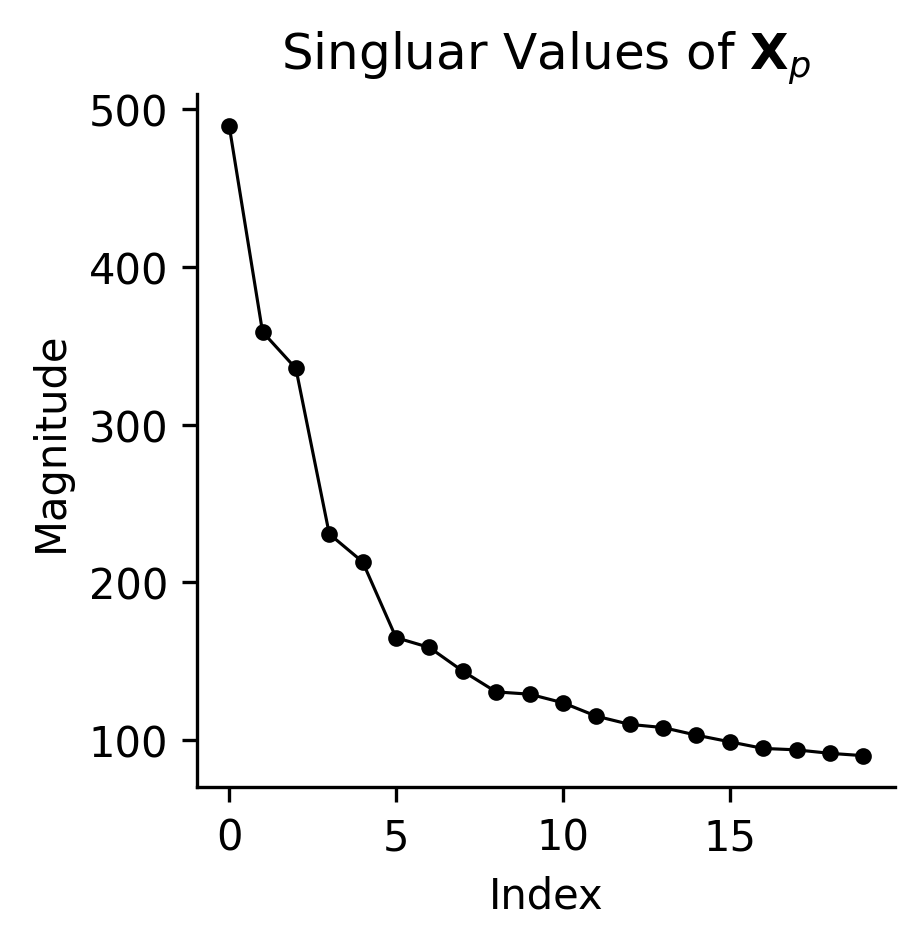

In [4]:
sval = dmd_res['SVD'][1]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "None"

plt.plot(sval[:20], lw=0.75, c='k', marker=".")
plt.title(r"Singluar Values of $\mathbf{X}_p$")
plt.ylabel(r"Magnitude")
plt.xlabel(r"Index")

plt.gca().set_facecolor("None")
sns.despine()

pdf.shape=(45, 2)


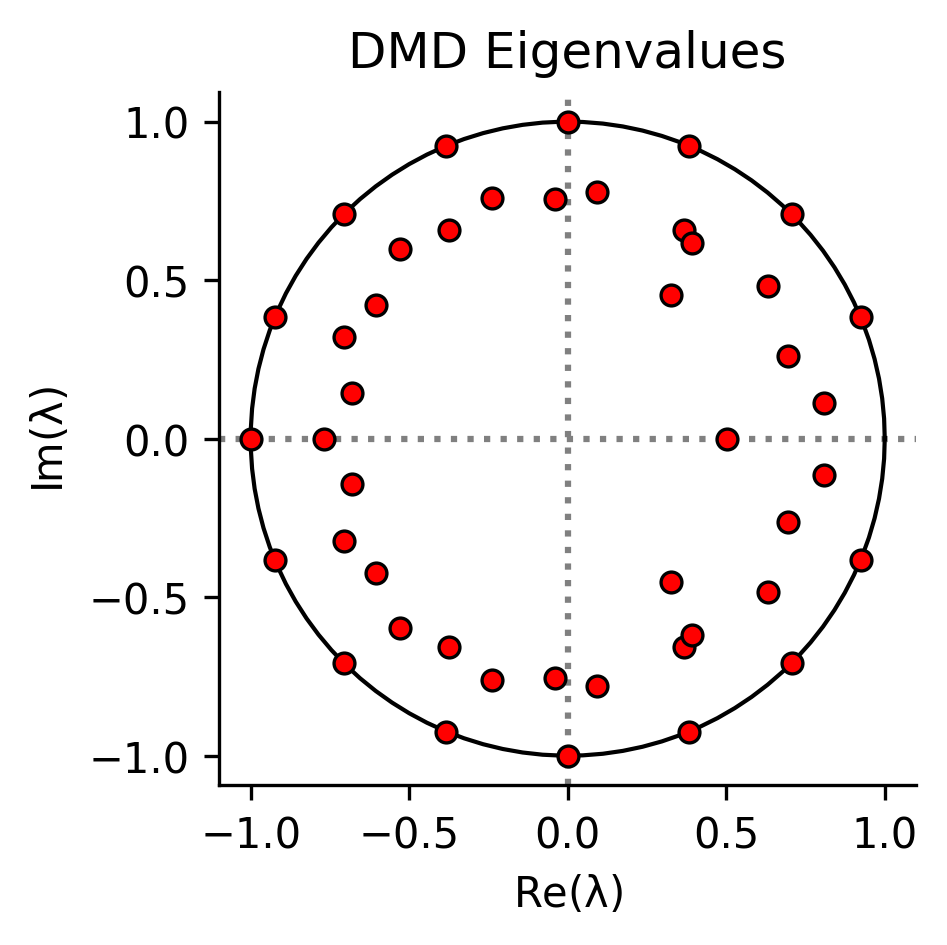

In [5]:
""" Plot DMD eigenvalues  """
t = np.linspace(0, np.pi*2, 100)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3

L = dmd_res['L']

# make the unit circle
plt.plot(np.cos(t), 
         np.sin(t), 
         linewidth=1, 
         c='k',
         zorder=1)

pdf = pd.DataFrame({'real' : np.real(L),
                    'imaginary' : np.imag(L)})

print(f"{pdf.shape=}")
pdf['mode'] = list(range(1, len(pdf)+1))

# plot the eigenvalues
sns.scatterplot(data=pdf,
                x='real', 
                y='imaginary',
                s=100,
                marker=".",
                legend=False,
                # hue='mode',
                c='r',
                ec='k',
                # palette='tab20',
                zorder=3)

# add the axis
plt.axvline(x=0, ls=":", c='grey', zorder=0)
plt.axhline(y=0, ls=":", c='grey', zorder=0)

plt.axis('equal')
plt.title("DMD Eigenvalues")
plt.xlabel(r'$\mathregular{Re(\lambda)}$')
plt.ylabel(r'$\mathregular{Im(\lambda)}$')

# sns.move_legend(plt.gca(), 
#                 title='Mode',
#                 frameon=False, 
#                 loc='upper right',
#                 bbox_to_anchor=(1.4, 1.1))

sns.despine()

L.shape=(45,) b.shape=(45, 16)


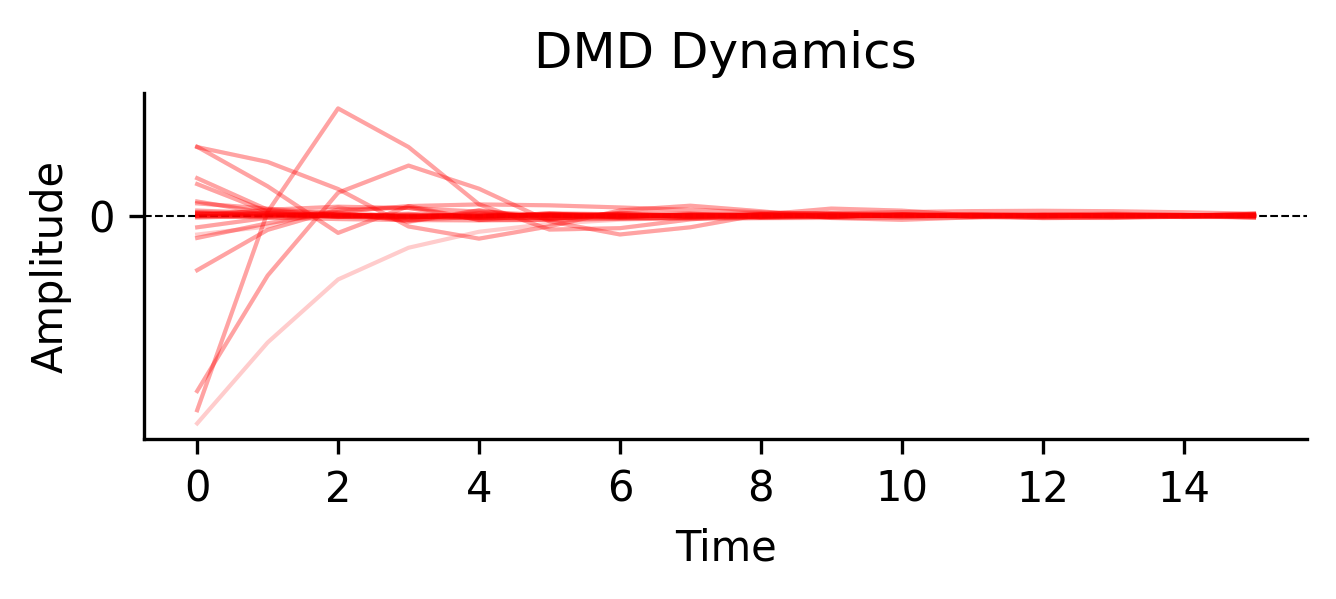

In [6]:
""" Plot the dynamics """
replicate = 0

L = dmd_res['L']
b = dmd_res['amplitudes'][replicate] 
print(f"{L.shape=} {b.shape=}")


pdf = []

for mode in range(L.shape[0]):
    scaled_mode = np.real(L[mode]*b[mode])
    smooth = savgol(scaled_mode,3,1)
    tmp = pd.DataFrame({'val' : scaled_mode,
                        'smooth' : smooth})
    
    tmp['time'] = list(range(len(tmp)))
    tmp['mode'] = mode + 1
    
    pdf.append(tmp)

pdf = pd.concat(pdf)
mask = (pdf['mode'] == 3)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 1.5

for m in pdf['mode'].unique():

    mask = (pdf['mode'] == m)

    sns.lineplot(data=pdf[mask], 
                 x='time',
                 y='smooth',
                 lw=1,
                 # color='r',
                 c="r",
                 alpha=0.2,
                 zorder=3)

plt.axhline(y=0, ls="--", lw=0.5, c='k', zorder=0)

plt.title("DMD Dynamics")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.yticks([0], [0])

# sns.move_legend(plt.gca(), 
#                 title='Mode',
#                 frameon=False, 
#                 loc='upper right',
#                 bbox_to_anchor=(1.4, 1.2))

sns.despine()

u_r.shape=(20967, 45)
X_pred.shape=(45, 48) with error: cd=1.000
X_pred.shape=(20967, 16, 3)


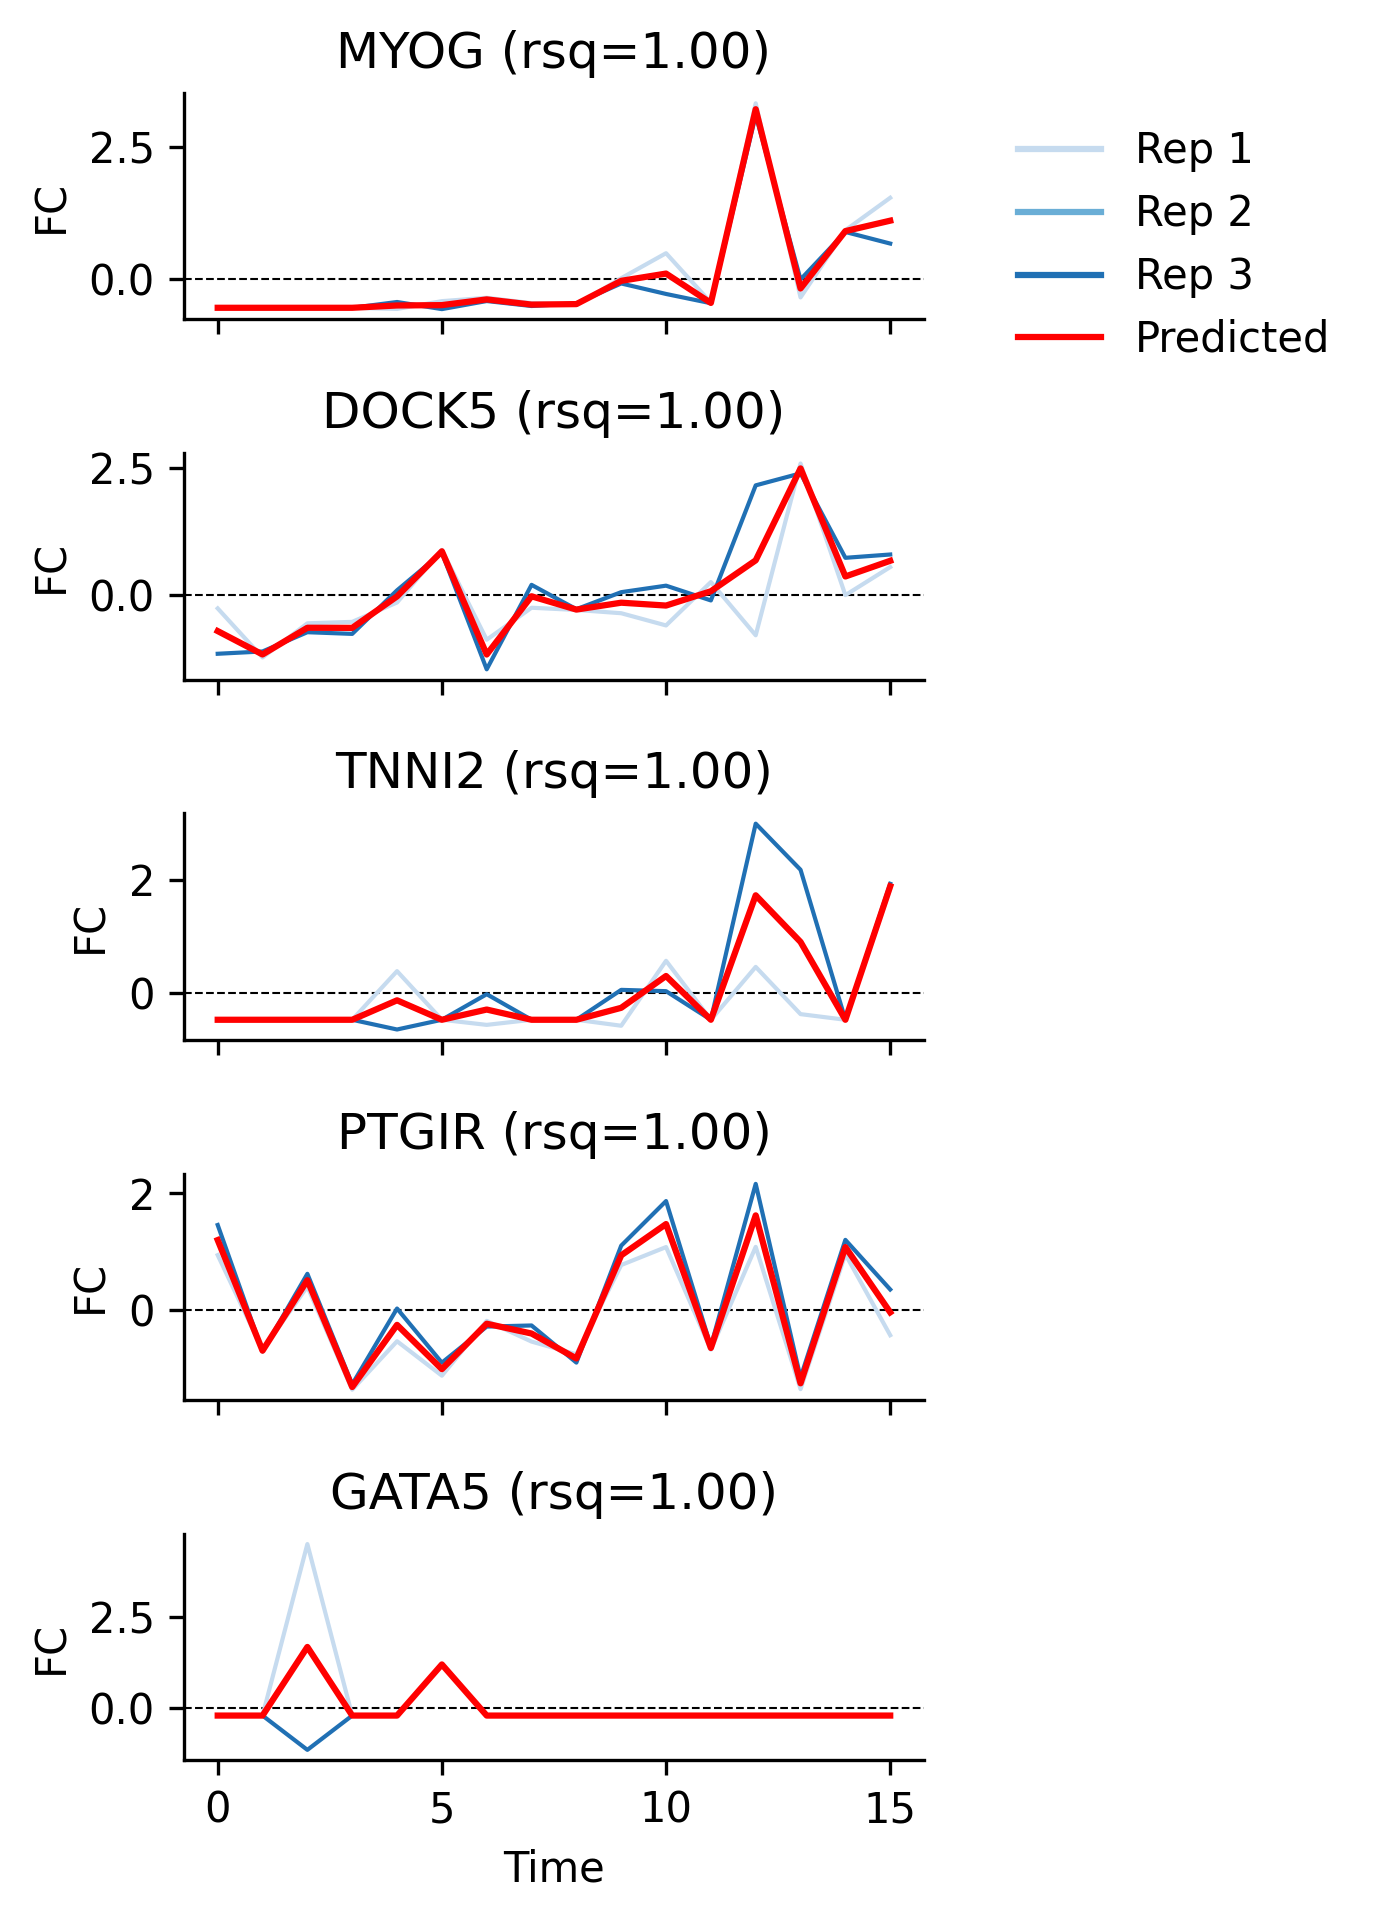

In [7]:
""" PREDICTIONS """

Atilde = dmd_res['Atilde']
u_r = dmd_res['u_r']
rank = dmd_res['rank']
data_embedded = dmd_res['data_embedded']
n, m, r = dmd_data.shape

X_pred, cd = hasnain_DMD.n_step_prediction(Atilde, data_embedded, m, r)
print(f"{u_r.shape=}")

print(f"{X_pred.shape=} with error: {cd=:.3f}")

X_pred = np.dot(u_r, X_pred)# rebuild full predictions
X_pred = X_pred.reshape(len(dmd_data), dmd_data.shape[1], dmd_data.shape[2], order='F')
print(f"{X_pred.shape=}")


genes = [ 
    'MYOG', 
    'DOCK5',
    'TNNI2', 
    'PTGIR',
    'GATA5',
]

r_ind = np.array([gene_names.index(x) for x in genes])
names = np.array(gene_names)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 1.3*len(genes)

fig, axs = plt.subplots(len(genes), 1, sharex=True)


def smooth(x):
    return savgol(x, 3, 1)

for i, g in enumerate(r_ind):

    g_name = names[g]
    actual = dmd_data[g]

    actual = np.apply_along_axis(smooth, 1, actual)

    actual = pd.DataFrame(actual, columns=['Rep 1', 'Rep 2', 'Rep 3'])
    actual['time'] = list(range(0, len(actual)))
    actual = pd.melt(actual, id_vars='time')

    sns.lineplot(data=actual, 
                 x='time',
                 y='value',
                 hue='variable',
                 lw=1,
                 ax=axs[i],
                 palette='Blues')

    act_mean = np.mean(dmd_data[g], axis=1).ravel()
    pred_mean = np.mean(X_pred[g], axis=1).ravel()

    corr, pval = scipy.stats.pearsonr(act_mean, pred_mean)

    axs[i].plot(pred_mean, color='r', label='Predicted')
    axs[i].axhline(y=0, ls="--", lw=0.5, c='k', zorder=0)
    axs[i].legend()

    if i == 0:

        sns.move_legend(axs[i],
                        loc='upper right',
                        title='',
                        bbox_to_anchor=(1.6, 1),
                        frameon=False,)
    else:
        axs[i].legend().remove()
    
    axs[i].set_ylabel("FC")
    axs[i].set_xlabel("Time")
    axs[i].set_title(f"{g_name} (rsq={corr:.2f})")

plt.tight_layout()
sns.despine()

res.shape=(100, 3)


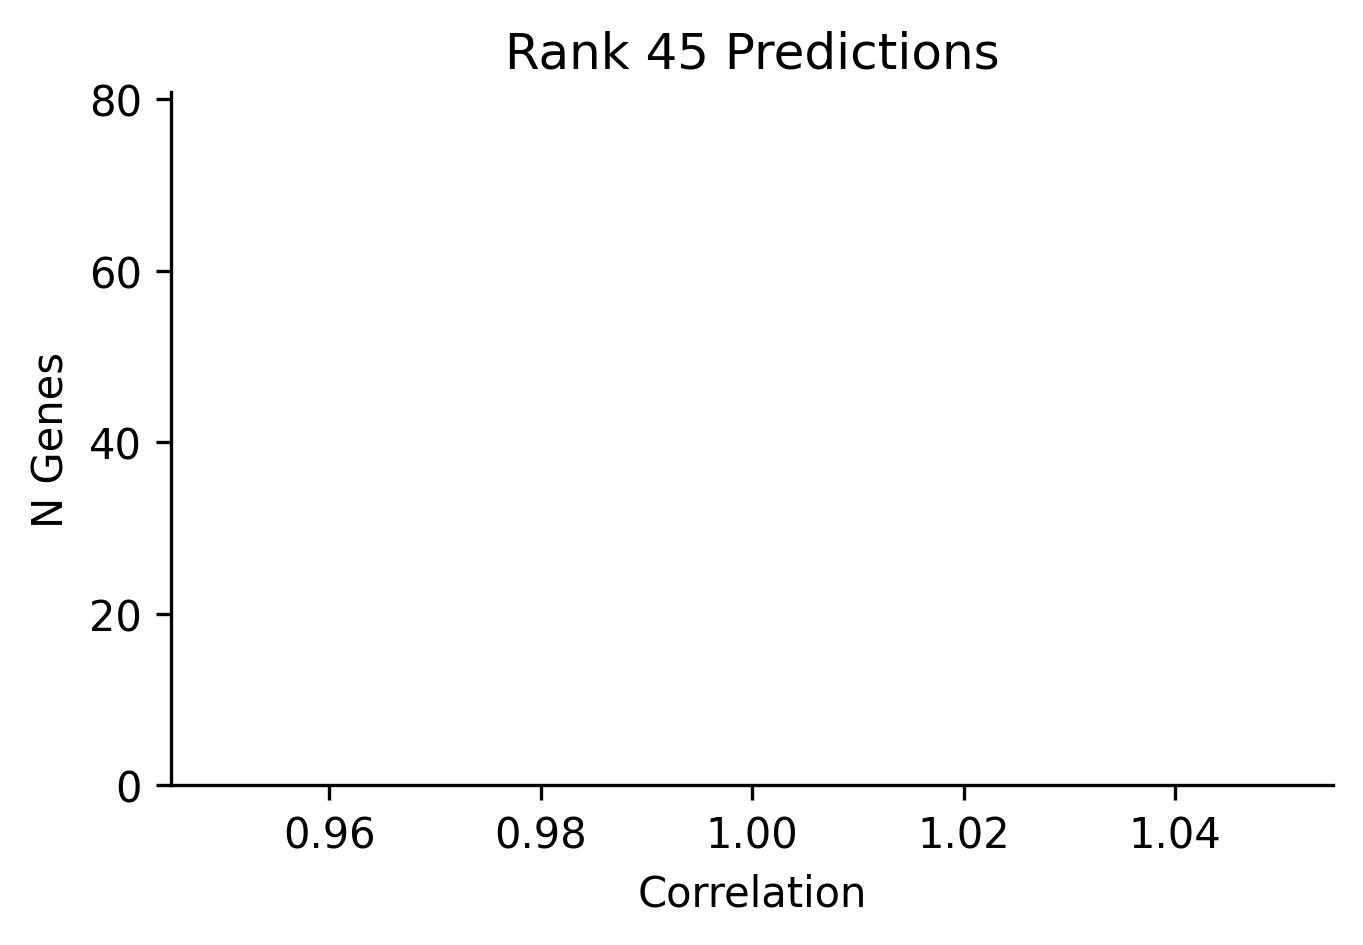

In [8]:
sample_size = 100
genes  = np.random.choice(gene_names, sample_size, replace=False)
r_ind = np.array([gene_names.index(x) for x in genes])


res = []
for i, g in zip(r_ind, genes):
    
    act_mean = np.mean(dmd_data[i], axis=1).ravel()
    pred_mean = np.mean(X_pred[i], axis=1).ravel()

    corr, pval = scipy.stats.pearsonr(act_mean, pred_mean)

    row = {
        'gene' : g,
        'corr' : corr,
        'pval' : pval,
    }
    res.append(row)

res = pd.DataFrame(res)
print(f"{res.shape=}")
res.head()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 3

sns.histplot(data=res, 
             x='corr',
             bins=20)

plt.xlabel('Correlation')
plt.ylabel('N Genes')
plt.title(f'Rank {rank} Predictions')
sns.despine()

In [9]:
# break

In [21]:
"""UMAP embedding for plotting """

# Phi = dmd_res['Phi_hat']
Phi = dmd_res['Phi']
X = np.real(Phi)
print(f"{Phi.shape=}")

n_neighbors = 11
min_dist = 0.5
mappy = umap.UMAP(n_components=2, 
                  n_neighbors=n_neighbors,
                  min_dist=min_dist)

edf = mappy.fit_transform(X)
edf = pd.DataFrame(edf, columns=['UMAP 1', 'UMAP 2'])
edf['gene_name'] = df.columns.to_list()
print(f"{edf.shape=}")

edf.head()

Phi.shape=(20967, 45)
edf.shape=(20967, 3)


,UMAP 1,UMAP 2,gene_name
0,-1.215267,-3.587785,A1BG
1,-4.168736,-4.637620,A1BG-AS1
2,0.486157,4.170756,A1CF
3,-3.368723,1.531126,A2M
4,-3.755944,-1.423539,A2M-AS1


C1     2799
C2     2481
C3     2459
C4     2295
C5     1976
C6     1616
C7     1546
C8     1417
C9     1365
C10    1276
C11    1155
C12     444
C13     138
Name: cluster_string, dtype: int64


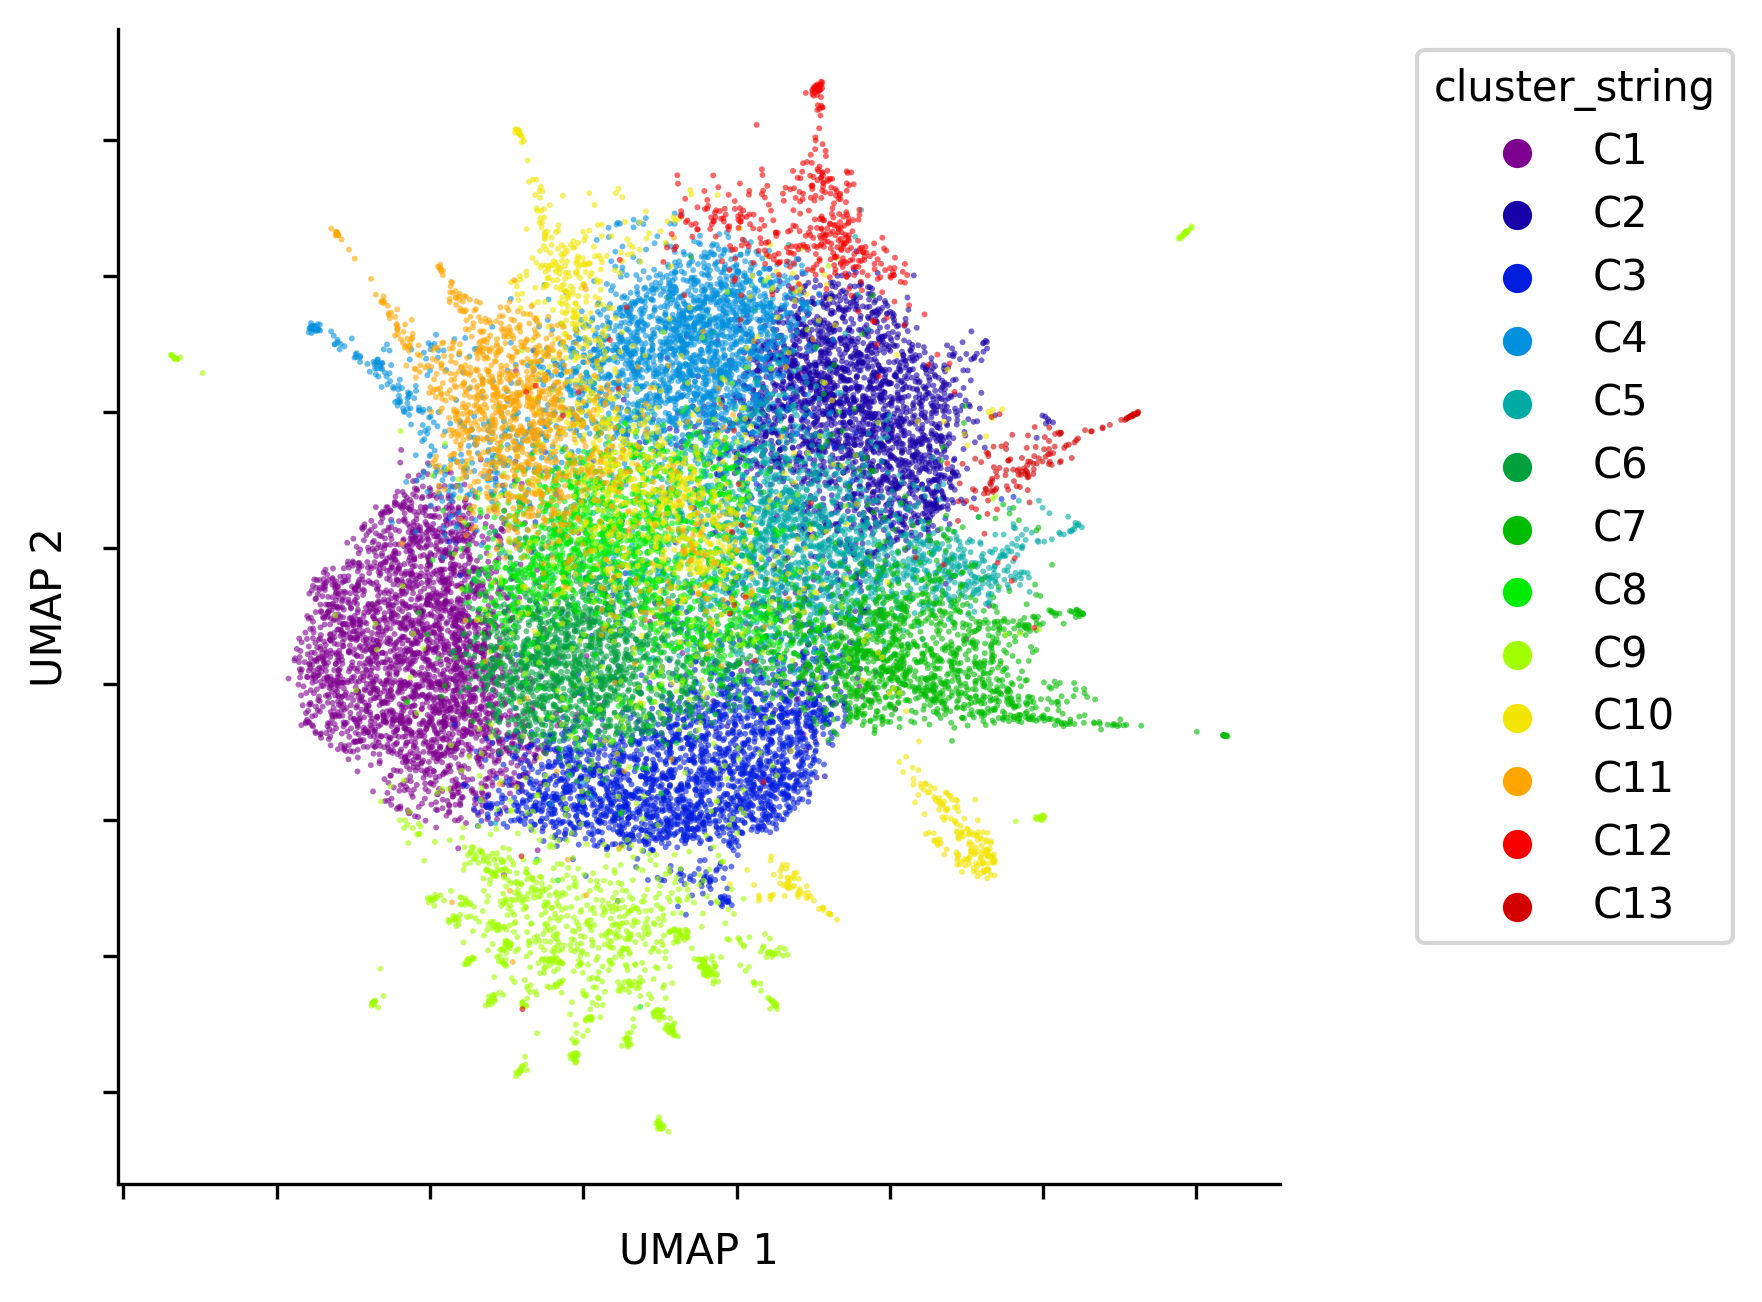

In [29]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

pdf = edf.copy()

pdf['cluster'] = ut.cluster(X, knn=71, resolution=0.01)
pdf['cluster'] = pdf['cluster'].astype(float) + 1
pdf['cluster'] = pdf['cluster'].astype(int) # for plotting purposes
pdf['cluster_string'] = pdf['cluster'].apply(lambda x: f"C{x}")

pdf = pdf.sort_values(by='cluster')

print(pdf['cluster_string'].value_counts())

sns.scatterplot(data=pdf, 
                x='UMAP 1',
                y='UMAP 2', 
                s=2,
                hue='cluster_string',
                palette='nipy_spectral',
                ec='None',
                lw=1,
                alpha=0.6)

ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])

sns.move_legend(ax, 
                loc='upper left',
                bbox_to_anchor=(1.1, 1))

sns.despine()

,UMAP 1,UMAP 2,gene_name,cluster,cluster_string,exp,exp_log
3690,-4.219707,-3.369292,COTL1,1,C1,1.004235,0.695262
10702,-5.177320,-2.726412,MB21D2,1,C1,1.015480,0.700857
11824,-4.242231,-3.855702,MSRB1,1,C1,0.984220,0.685226
17269,-5.041757,-1.680051,SNX7,1,C1,1.005030,0.695659
4742,-6.803400,-0.590819,DSCC1,1,C1,1.009611,0.697941


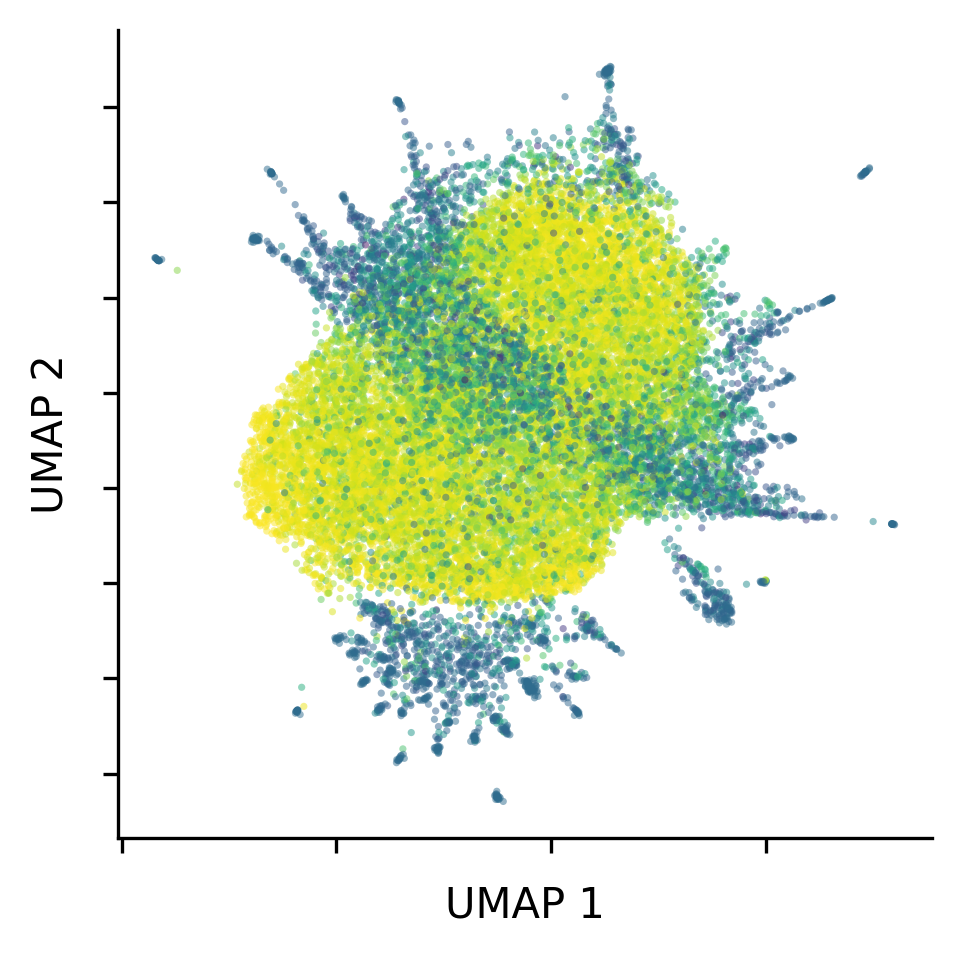

In [33]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3.5, 3.5

def get_gene(x):
    return mu_data[x].std()

pdf['exp'] = pdf['gene_name'].apply(lambda x: get_gene(x))
pdf['exp_log'] = np.log1p(pdf['exp'])

sns.scatterplot(data=pdf, 
                x='UMAP 1',
                y='UMAP 2',
                s=3,
                hue='exp',
                palette='viridis',
                ec='None',
                legend=False,
                lw=1,
                alpha=0.5)

ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
sns.despine()

pdf.head()

In [49]:
""" Who are the C7 genes? """

n_gene = 500
cid = "C2"

cdf = pdf[pdf['cluster_string'] == cid]
print(f"{cdf.shape=}")

# aggregating fold change by sum shows genes diverging from the initial condition
# standard deviation shows genes that have 'interesting' dynamics
cdf = cdf.sort_values(by='exp', ascending=False)

genes = cdf['gene_name'].head(n_gene).to_list()

db = 'GO_Biological_Process_2023'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

enrich = gget.enrichr(genes, database=db)
enrich[['path_name', 'adj_p_val', 'overlapping_genes']].head(10)

Tue Sep 19 15:23:08 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2023.


cdf.shape=(2481, 7)


,path_name,adj_p_val,overlapping_genes
0,Regulation Of Transcription By RNA Polymerase ...,2.027402e-12,"[CRTC3, PRDM4, ZBTB20, RORA, CREB3L4, ZNF844, ..."
1,Negative Regulation Of Transcription By RNA Po...,1.607518e-10,"[ZNF254, TCP10L, ZBTB20, GLI3, FLCN, TRPS1, EP..."
2,Negative Regulation Of DNA-templated Transcrip...,3.632838e-10,"[ZNF254, TCP10L, CDKN1B, ZC3H4, ZBTB20, GLI3, ..."
3,Regulation Of DNA-templated Transcription (GO:...,6.257704e-09,"[PRDM4, RORA, GPATCH3, CREB3L4, ZNF844, EP300,..."
4,Regulation Of Gene Expression (GO:0010468),1.521832e-03,"[USP36, ZBTB20, RORA, LITAF, FLCN, TRIM4, ATXN..."
5,Regulation Of Glycolytic Process (GO:0006110),1.981114e-03,"[HDAC4, P2RX7, FLCN, INSR, ZBTB20, EP300, PPAR..."
6,Positive Regulation Of Small Molecule Metaboli...,4.401225e-03,"[P2RX7, SLC45A3, INSR, PRKCE, ZBTB20, PMAIP1, ..."
7,Positive Regulation Of Carbohydrate Metabolic ...,4.745755e-03,"[P2RX7, SLC45A3, INSR, PRKCE, ZBTB20, PMAIP1, ..."
8,Negative Regulation Of Nucleic Acid-Templated ...,8.405037e-03,"[HDAC4, CDKN1B, PRDM11, GLI3, HMBOX1, BCL7A, B..."
9,Negative Regulation Of Glycolytic Process (GO:...,1.517019e-02,"[HDAC4, FLCN, PPARA, GIT1]"


In [16]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# """ Cluster Genes """


# """UMAP embedding for plotting """
# n_neighbors = 100
# min_dist = 0.8
# mappy = umap.UMAP(n_components=2, 
#                   n_neighbors=n_neighbors,
#                   min_dist=min_dist)

# edf = mappy.fit_transform(X)
# edf = pd.DataFrame(edf, columns=['UMAP 1', 'UMAP 2'])
# print(f"{edf.shape=}")

# break

# Compare with separate DMD models

In [50]:
# compare with 3 separate DMDs

data = df.copy()

labels = pd.DataFrame(data.index, columns=['expId'])
labels['time'] = labels['expId'].apply(lambda x: x.split("_")[0])
labels['replicate'] = labels['expId'].apply(lambda x: x.split("_")[1])

replicates = sorted(labels['replicate'].unique())

rep_data = {}

for r in replicates:
    # get the indices of the replicate
    ind = labels[labels['replicate'] == r]['expId'].to_list()
    t_data = data.loc[ind].T
    t_data = np.expand_dims(t_data, 2)
    print(r, t_data.shape)
    rep_data[r] = t_data

print('done')

R1 (20967, 16, 1)
R2 (20967, 16, 1)
R3 (20967, 16, 1)
done


R1: dmd_res['A'].shape=(20967, 20967)
R1: dmd_res['Atilde'].shape=(15, 15)
R1: dmd_res['u_r'].shape=(20967, 15)
R1: dmd_res['L'].shape=(15,)
R1: dmd_res['W'].shape=(15, 15)
R1: dmd_res['Phi'].shape=(20967, 15)
R1: dmd_res['amplitudes'][0].shape=(15, 16)

R2: dmd_res['A'].shape=(20967, 20967)
R2: dmd_res['Atilde'].shape=(15, 15)
R2: dmd_res['u_r'].shape=(20967, 15)
R2: dmd_res['L'].shape=(15,)
R2: dmd_res['W'].shape=(15, 15)
R2: dmd_res['Phi'].shape=(20967, 15)
R2: dmd_res['amplitudes'][0].shape=(15, 16)

R3: dmd_res['A'].shape=(20967, 20967)
R3: dmd_res['Atilde'].shape=(15, 15)
R3: dmd_res['u_r'].shape=(20967, 15)
R3: dmd_res['L'].shape=(15,)
R3: dmd_res['W'].shape=(15, 15)
R3: dmd_res['Phi'].shape=(20967, 15)
R3: dmd_res['amplitudes'][0].shape=(15, 16)



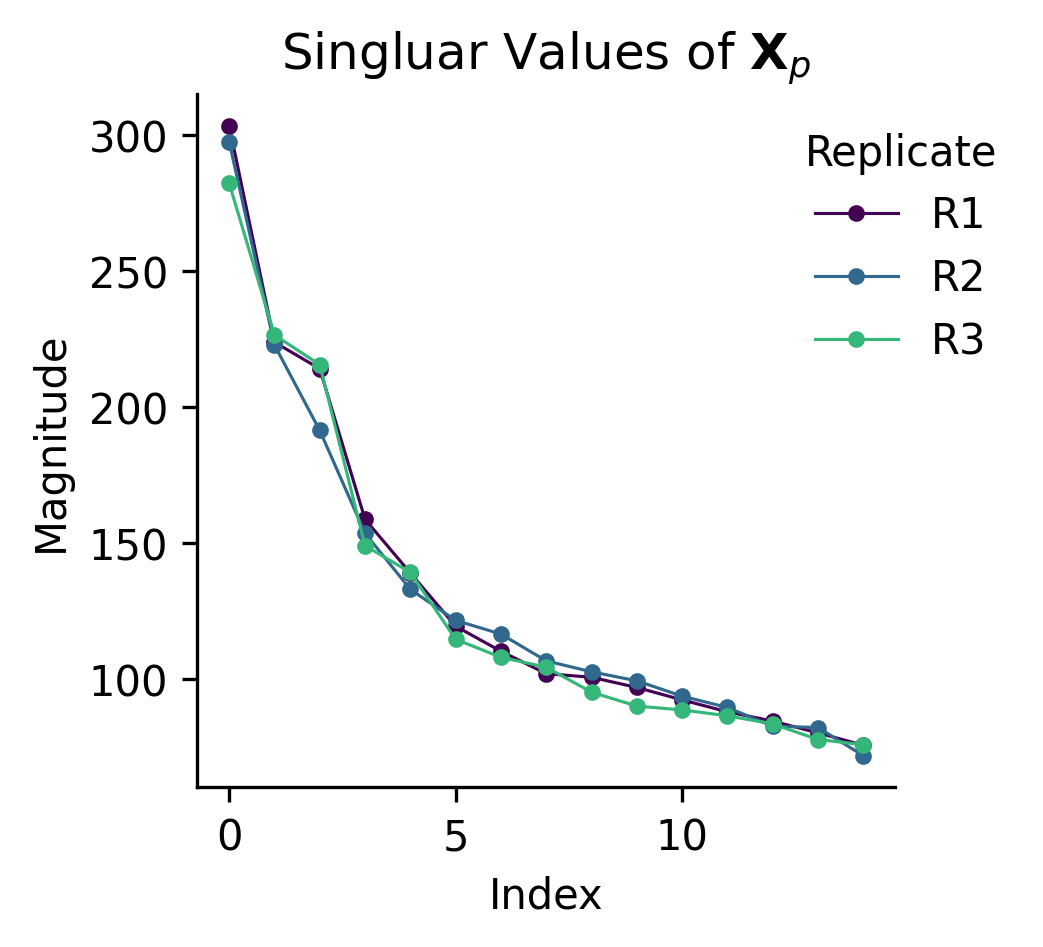

In [51]:
rank = 15 # when None == optimal hard threshold  
exact = False # when false, this is exact DMD

res = {}

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "None"

colors = ut.ncolor(4, cmap='viridis')
colorMap = dict(zip(rep_data.keys(), colors))

for rep, t_data in rep_data.items():
    dmd_res = hasnain_DMD.dmd(t_data, exact=exact, rank=rank)

    print(f"{rep}: {dmd_res['A'].shape=}")
    print(f"{rep}: {dmd_res['Atilde'].shape=}")
    print(f"{rep}: {dmd_res['u_r'].shape=}")
    print(f"{rep}: {dmd_res['L'].shape=}")
    print(f"{rep}: {dmd_res['W'].shape=}")
    print(f"{rep}: {dmd_res['Phi'].shape=}")
    print(f"{rep}: {dmd_res['amplitudes'][0].shape=}")
    print()

    res[rep] = dmd_res
    sval = dmd_res['SVD'][1]
    
    plt.plot(sval, 
             lw=0.75, 
             c=colorMap[rep], 
             marker=".",
             label=rep)

    # break

plt.title(r"Singluar Values of $\mathbf{X}_p$")
plt.ylabel(r"Magnitude")
plt.xlabel(r"Index")

plt.legend()
sns.move_legend(plt.gca(),
                title='Replicate',
                loc='upper right',
                frameon=False,
                bbox_to_anchor=(1.2, 1))

plt.gca().set_facecolor("None")
sns.despine()

R1 error: cd=1.000
X_pred.shape=(20967, 16, 1)
R2 error: cd=1.000
X_pred.shape=(20967, 16, 1)
R3 error: cd=1.000
X_pred.shape=(20967, 16, 1)


/home/cstansbu/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


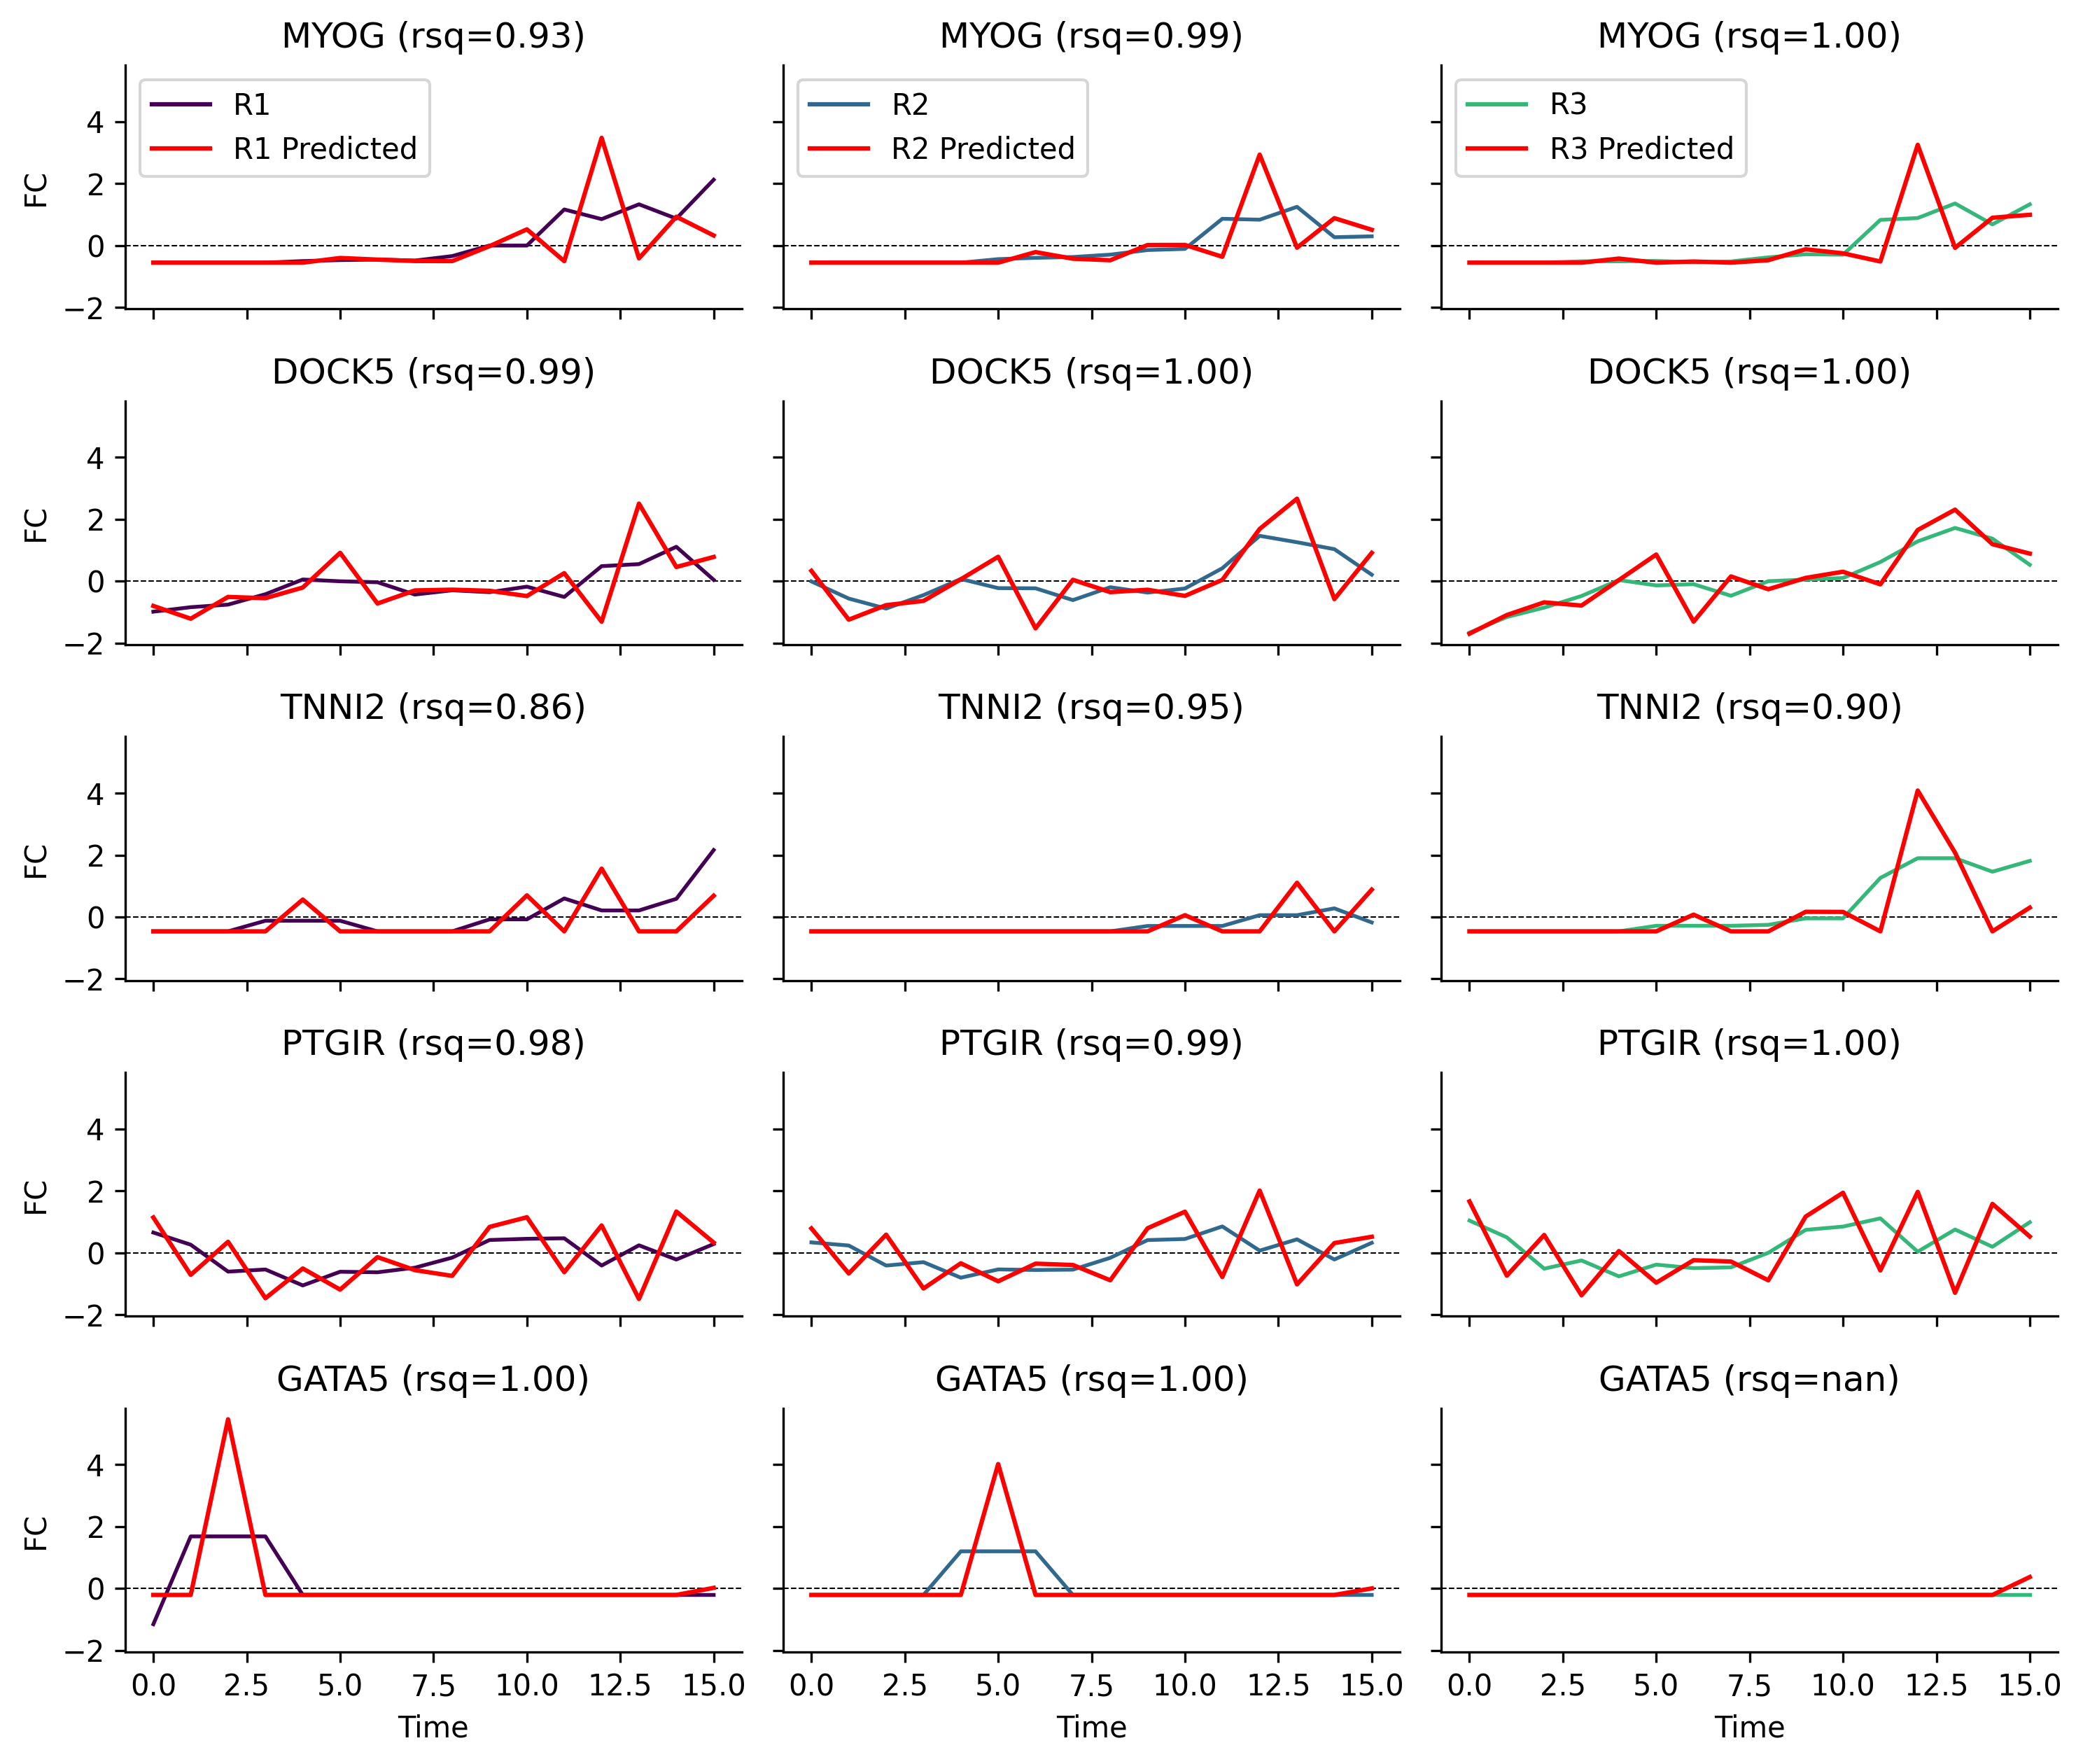

In [52]:
""" PREDICTIONS """

genes = [ 
    'MYOG', 
    'DOCK5',
    'TNNI2', 
    'PTGIR',
    'GATA5',
]

r_ind = np.array([gene_names.index(x) for x in genes])
names = np.array(gene_names)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 1.7*len(genes)

fig, axs = plt.subplots(len(genes), 3, sharex=True, sharey=True)

rep_count = 0
for rep, dmd_res in res.items():
    
    Atilde = dmd_res['Atilde']
    u_r = dmd_res['u_r']
    rank = dmd_res['rank']
    data_embedded = dmd_res['data_embedded']
    n, m, r = rep_data[rep].shape

    X_pred, cd = hasnain_DMD.n_step_prediction(Atilde, data_embedded, m, r)
    print(f"{rep} error: {cd=:.3f}")

    X_pred = np.dot(u_r, X_pred)# rebuild full predictions
    X_pred = X_pred.reshape(len(rep_data[rep]), rep_data[rep].shape[1], rep_data[rep].shape[2], order='F')
    print(f"{X_pred.shape=}")

    for i, g in enumerate(r_ind):

        g_name = names[g]
        actual = rep_data[rep][g]
        actual = np.apply_along_axis(smooth, 0, actual)
        actual = pd.DataFrame(actual, columns=[rep])
        actual['time'] = list(range(0, len(actual)))
        actual = pd.melt(actual, id_vars='time')

    
    
        sns.lineplot(data=actual, 
                     x='time',
                     y='value',
                     hue='variable',
                     lw=1.3,
                     ax=axs[i, rep_count],
                     palette=[colorMap[rep]])
    
        act_mean = np.mean(rep_data[rep][g], axis=1).ravel()
        pred_mean = np.mean(X_pred[g], axis=1).ravel()
    
        corr, pval = scipy.stats.pearsonr(act_mean, pred_mean)

        axs[i, rep_count].plot(pred_mean, 
                    color='r', 
                    label=f'{rep} Predicted')
        axs[i, rep_count].axhline(y=0, ls="--", lw=0.5, c='k', zorder=0)
        axs[i, rep_count].legend()

        if i == 0:

            sns.move_legend(axs[i, rep_count],
                            loc='upper left',
                            title='',
                            frameon=True,)
        else:
            axs[i, rep_count].legend().remove()

        axs[i, rep_count].set_ylabel("FC")
        axs[i, rep_count].set_xlabel("Time")
        axs[i, rep_count].set_title(f"{g_name} (rsq={corr:.2f})")
    rep_count += 1

plt.tight_layout()
sns.despine()

In [ ]:
break

In [ ]:
break

In [ ]:
# """ Experiment with the rank """

# exact = False # when false, this is exact DMD
# lower = 10
# upper = 35
# n = 5
# rank_vals = np.linspace(lower, upper, n).astype(int)

# res = []

# for rank in rank_vals:
#     tmp = dmd(dmd_data, exact=exact, rank=rank, verbose=False)
#     print(f"computing rank {rank}...")
#     L = tmp['L']

#     pdf = pd.DataFrame({'real' : np.real(L),
#                         'imaginary' : np.imag(L)})
    
#     pdf['mode'] = list(range(1, len(pdf)+1))
#     pdf['rank'] = rank
#     pdf['error'] = tmp['cd']

#     res.append(pdf)


# res = pd.concat(res)
# print(f"{res.shape=}")

In [ ]:
# plt.plot(np.cos(t), 
#          np.sin(t), 
#          linewidth=1, 
#          c='k',
#          zorder=1)

# sns.scatterplot(data=res,
#                 x='real', 
#                 y='imaginary',
#                 s=30,
#                 hue='rank',
#                 ec='none',
#                 palette='viridis',
#                 alpha=0.5,
#                 zorder=3)

# # add the axis
# plt.axvline(x=0, ls=":", c='grey', zorder=0)
# plt.axhline(y=0, ls=":", c='grey', zorder=0)
# plt.axis('equal')
# plt.title("DMD Modes")
# plt.xlabel(r'$\mathregular{Re(\lambda)}$')
# plt.ylabel(r'$\mathregular{Im(\lambda)}$')

# sns.move_legend(plt.gca(), 
#                 title='Rank',
#                 frameon=False, 
#                 loc='upper right',
#                 bbox_to_anchor=(1.4, 1.1))

In [ ]:
# replicate = 0

# L = dmd_res['L']
# b = dmd_res['amplitudes'][replicate] 
# print(f"{L.shape=} {b.shape=}")


# pdf = []

# for mode in range(L.shape[0]):
#     scaled_mode = np.real(L[mode]*b[mode])
#     smooth = savgol(scaled_mode,3,1)
#     tmp = pd.DataFrame({'val' : scaled_mode,
#                         'smooth' : smooth})
    
#     tmp['time'] = list(range(len(tmp)))
#     tmp['mode'] = mode + 1
    
#     pdf.append(tmp)

# pdf = pd.concat(pdf)
# mask = (pdf['mode'] == 3)


# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 5, 1.5

# for m in pdf['mode'].unique():

#     mask = (pdf['mode'] == m)

#     sns.lineplot(data=pdf[mask], 
#                  x='time',
#                  y='smooth',
#                  lw=1,
#                  # color='r',
#                  c="r",
#                  alpha=0.2,
#                  zorder=3)

# plt.axhline(y=0, ls="--", lw=0.5, c='k', zorder=0)

# plt.title("DMD Dynamics")
# plt.xlabel("Time")
# plt.ylabel("Amplitude")

# plt.yticks([0], [0])

# # sns.move_legend(plt.gca(), 
# #                 title='Mode',
# #                 frameon=False, 
# #                 loc='upper right',
# #                 bbox_to_anchor=(1.4, 1.2))

# sns.despine()

In [ ]:
# break

In [ ]:
# """ PREDICTIONS """

# Atilde = dmd_res['Atilde']
# u_r = dmd_res['u_r']
# rank = dmd_res['rank']
# n, m, r = dmd_data.shape

# data_embedded = np.zeros((rank, m, r))

# for i in range(r):
#     data_embedded[:,:,i] = np.dot(u_r.T, dmd_data[:,:,i])

# X_pred, cd = n_step_prediction(Atilde, data_embedded, m, r)
# print(f"{u_r.shape=}")


# print(f"{X_pred.shape=} with error: {cd=:.3f}")

# X_pred = np.dot(u_r, X_pred) # rebuild full observability
# X_pred = X_pred.reshape(len(dmd_data), dmd_data.shape[1], dmd_data.shape[2], order='F')
# print(f"{X_pred.shape=}")


# """ Select genes """
# n_genes = 2
# r_ind = np.random.choice(list(range(len(gene_names))), n_genes)
# names = np.array(gene_names)


# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 6, 1.3*n_genes

# fig, axs = plt.subplots(n_genes, 1, sharex=True)


# for i, g in enumerate(r_ind):

#     g_name = names[g]
#     actual = dmd_data[g]

#     actual = pd.DataFrame(actual, columns=['Rep 1', 'Rep 2', 'Rep 3'])
#     actual['time'] = list(range(1, len(actual) + 1))

#     actual = pd.melt(actual, id_vars='time')

#     sns.lineplot(data=actual, 
#                  x='time',
#                  y='value',
#                  hue='variable',
#                  lw=1,
#                  ax=axs[i],
#                  palette='Blues')

#     act_mean = np.mean(dmd_data[g], axis=1).ravel()
#     pred_mean = np.mean(X_pred[g], axis=1).ravel()

#     corr, pval = scipy.stats.pearsonr(act_mean, pred_mean)

#     axs[i].plot(pred_mean, color='r', label='Predicted')
#     axs[i].axhline(y=0, ls="--", lw=0.5, c='k', zorder=0)
#     axs[i].legend()

#     if i == 0:

#         sns.move_legend(axs[i],
#                         loc='upper right',
#                         title='',
#                         bbox_to_anchor=(1.6, 1),
#                         frameon=False,)
#     else:
#         axs[i].legend().remove()
    
#     axs[i].set_ylabel("Fold Change")
#     axs[i].set_xlabel("Time")
#     axs[i].set_title(f"{g_name} (rsq={corr:.2f})")

# plt.tight_layout()
# sns.despine()

In [ ]:
""" PREDICTIONS """

Atilde = dmd_res['Atilde']
u_r = dmd_res['u_r']
rank = dmd_res['rank']
n, m, r = dmd_data.shape

data_embedded = embed_data

for i in range(r):
    data_embedded[:,:,i] = np.dot(u_r.T, dmd_data[:,:,i])

X_pred, cd = n_step_prediction(Atilde, data_embedded, m, r)
print(f"{u_r.shape=}")


print(f"{X_pred.shape=} with error: {cd=:.3f}")

X_pred = np.dot(u_r, X_pred)# rebuild full observability
X_pred = X_pred.reshape(len(dmd_data), dmd_data.shape[1], dmd_data.shape[2], order='F')
print(f"{X_pred.shape=}")


genes = [
    # 'TNNC1', 
    # 'MYH7', 
    'MYOG', 
    'DOCK5', 
    # 'TNNT3', 
    # 'ACTN2', 
    # 'MYH8', 
    # 'MYH1', 
    # 'CKM',
    # 'MYL1',
    # 'ACTA1',
    # 'MYLPF', 
    # 'TNNI1', 
    'TNNI2', 
    'PTGIR',
    'GATA5',
    # 'ZBTB16'
]

r_ind = np.array([gene_names.index(x) for x in genes])
names = np.array(gene_names)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 1.3*len(genes)

fig, axs = plt.subplots(len(genes), 1, sharex=True)


def smooth(x):
    return savgol(x, 3, 1)


for i, g in enumerate(r_ind):

    g_name = names[g]
    actual = dmd_data[g]

    actual = np.apply_along_axis(smooth, 1, actual)

    actual = pd.DataFrame(actual, columns=['Rep 1', 'Rep 2', 'Rep 3'])
    actual['time'] = list(range(0, len(actual)))
    actual = pd.melt(actual, id_vars='time')

    sns.lineplot(data=actual, 
                 x='time',
                 y='value',
                 hue='variable',
                 lw=1,
                 ax=axs[i],
                 palette='Blues')

    act_mean = np.mean(dmd_data[g], axis=1).ravel()
    pred_mean = np.mean(X_pred[g], axis=1).ravel()

    corr, pval = scipy.stats.pearsonr(act_mean, pred_mean)

    axs[i].plot(pred_mean, color='r', label='Predicted')
    axs[i].axhline(y=0, ls="--", lw=0.5, c='k', zorder=0)
    axs[i].legend()

    if i == 0:

        sns.move_legend(axs[i],
                        loc='upper right',
                        title='',
                        bbox_to_anchor=(1.6, 1),
                        frameon=False,)
    else:
        axs[i].legend().remove()
    
    axs[i].set_ylabel("FC")
    axs[i].set_xlabel("Time")
    axs[i].set_title(f"{g_name} (rsq={corr:.2f})")

plt.tight_layout()
sns.despine()

In [ ]:
# break

In [ ]:
# for replicate in dmd_res['amplitudes']:
#     print(f"{replicate.shape=}")

#     sns.lineplot(np.real(replicate).T)
#     # plt.imshow(np.real(replicate))
#     break

In [ ]:
# # cluster genes by modes
# phi = dmd_res['Phi']
# print(f"{phi.shape=}")


# """UMAP embedding for plotting """
# n_neighbors = 11
# min_dist = 0.8
# mappy = umap.UMAP(n_components=2, 
#                   n_neighbors=n_neighbors,
#                   min_dist=min_dist)

# edf = mappy.fit_transform(np.real(phi))
# edf = pd.DataFrame(edf, columns=['UMAP1', 'UMAP2'])

# edf.head()

# sns.scatterplot(data=edf,
#                 x='UMAP1',
#                 y='UMAP2',
#                 ec='none')

In [ ]:
# break

In [ ]:
# for replicate in dmd_res['amplitudes']:
#     print(f"{replicate.shape=}")

#     sns.lineplot(np.real(replicate))
#     # plt.imshow(np.real(replicate))
#     break

In [ ]:
# break

In [ ]:
def gram_matrix(A, x0, nT=50, reduced=True, projection_matrix=np.array([])):
    '''
    A: matrix representation of the Koopman operator
    x0: initial conditions from measurements
    nT: number of timepoints over which to compute the Gram matrix
    reduced: if True, will compute reduced G from reduced data and KO and will also return full G after inverse projection
    projection_matrix: the matrix used to project data and KO to low-dimensional space (first r eigenvectors of Data.T @ Data)
    Both A and x0 can be either the full dimensional data and KO or they can be the DMD projected data and KO
    If projected, then return both the projected G and the full G after inverting the projection
    If not projected, then compute full G (can be slow, especially if the data dimension exceeds a couple thousand)
    Furthermore, for sensor placement we need to compute the eigendecomposition of G, so having the reduced G is handy   
    '''

    # generate artificial initial conditions for robust optimization 
    # get the min and max of each gene's initial value
    x0min = np.min(x0, axis=1)
    x0max = np.max(x0, axis=1)
    # form a set of new initial conditions distributed uniformly from x0min to x0max
    numICs = x0.shape[0]
    x0uni = np.zeros((len(x0min),numICs))
    x0uni[:,0:x0.shape[1]] = deepcopy(x0)
    for ii in range(x0.shape[1], x0uni.shape[1]):
        x0tmp = np.random.uniform(x0min,x0max)
        x0uni[:,ii] = x0tmp

    G = np.zeros_like(A)
    for ii in range(nT):
        print(f"{ii}...")
        A_pow = np.linalg.matrix_power(A,ii)
        G += np.matmul( np.matmul(A_pow, x0uni), np.matmul(x0uni.T, A_pow.T) ) 
    # right eigenvectors of G (columns of V) are rows of the gene sampling matrix (or vector if just one eigvec kept)

    if reduced: 
        Gfull = np.matmul(np.matmul(projection_matrix, G), projection_matrix.T)
        return G, Gfull
    else: 
        return G # this is the full G, computed directly from full KO and data


A = dmd_res['Atilde']
u = dmd_res['u_r']
nT = 16
G, Gfull = gram_matrix(A, data_embedded[:,0,:], nT=nT, reduced=True, projection_matrix=u)
print(f"{G.shape=} {Gfull.shape=}")

In [ ]:
# compute eigendecomposition of the Gram matrices
# right eigenvectors of G (columns of V) are rows of the gene sampling matrix 
D, V = np.linalg.eig(G)
print(f"{D.shape=}{ V.shape=}")

In [ ]:
break

In [ ]:
U_r = dmd_res['u_r']
Atilde = dmd_res['Atilde']
rank = dmd_res['rank']

n, m, r = dmd_data.shape

# create a prediction object
X0 = np.zeros((rank, m, r))
print(f"{X0.shape=}")

for i in range(r):
    X0[:,:,i] = np.dot(U_r.T, dmd_data[:,:,i])

# make the predicitions
X_pred_red, cd_red = n_step_prediction(Atilde, X0, m, r)
print(f"{cd_red=:.3f} {X_pred_red.shape=}")

In [ ]:
break

In [ ]:
""" Another way"""

In [ ]:
W

# Error Plots

In [ ]:
# reshape the input
replicate = 2 # zero-indexed!
time = 10

X0 = dmd_data[:, 0, replicate]
Xf = dmd_data[:, time-1, replicate]

print(f"{X0.shape=}")
print(f"{Xf.shape=}")

Ahat = np.linalg.matrix_power(Atilde, time)
AhatExp = U_r@Ahat@U_r.T
print(f"{Ahat.shape=} {AhatExp.shape=}")

rec = np.dot(AhatExp, X0)
print(f"{rec.shape=}")

err = np.linalg.norm(rec - Xf)
score, pval = scipy.stats.pearsonr(rec, Xf)
print(f"Error: {err=:.3f}, correlation: {score=:.3f} ({pval=:3f})")

# dmd_data.shape

# n, m, r = dmd_data.shape
# # print(f"input {dmd_data.shape=} {n=} {m=} {r=}")
# X0 = dmd_data[:,:-1].reshape(n,(m-1)*r, order='F') 
# print(f"{X0.shape=}")

In [ ]:
replicate = 2 # zero-indexed!
time = 15

X0 = dmd_data[:, 0, replicate]

res = []

for t in np.linspace(0, time, time+1):

    # the expression at this time
    Xf = dmd_data[:, time-1, replicate]

    # the transition matrix
    Ahat = np.linalg.matrix_power(Atilde, int(t))
    AhatExp = U_r@Ahat@U_r.T

    rec = np.dot(AhatExp, X0)

    err = np.linalg.norm(rec - Xf)
    score, pval = scipy.stats.pearsonr(rec, Xf)

    row = {
        'time' : t,
        'error' : err,
        'score' : score,
        'pval' : pval,
    }

    res.append(row)


res = pd.DataFrame(res)

sns.lineplot(data=res, 
            x='time',
            y='error')


res.head()

In [ ]:
break

In [ ]:
break

In [ ]:
break

In [ ]:
""" plot reconstruction error """

In [ ]:
""" Cluster genes based on the temporal modes """


In [ ]:
""" perform observability analysis """